First few rows of the DataFrame:
   Input   kP    kI   kD  Output
0    320  0.1  0.01  0.0   33.60
1    310  0.1  0.01  0.0   34.15
2    300  0.1  0.01  0.0   34.65
3    290  0.1  0.01  0.0   35.10
4    280  0.1  0.01  0.0   35.50


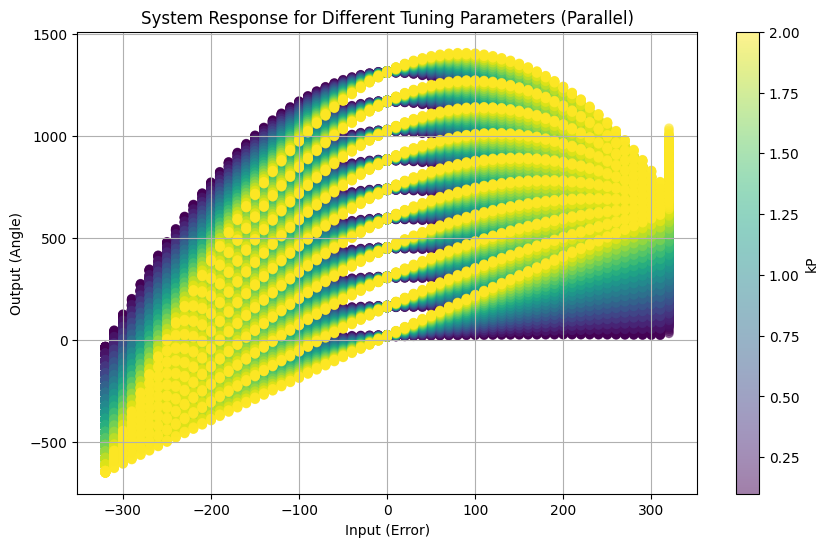

Data saved to tuning_results_parallel.xlsx


In [1]:
import pandas as pd
import numpy as np
from pid_sm import PIDController
import concurrent.futures
import matplotlib.pyplot as plt

# Function to simulate the system response using the PID controller
def simulate_system_response(params):
    kp, ki, kd, pid_controller, setpoint, object_centers = params
    pid_controller.reset()

    data = {'Input': [], 'kP': [], 'kI': [], 'kD': [], 'Output': []}

    for object_center in object_centers:
        error = setpoint - object_center
        output = pid_controller.update(error)

        # Append values to the data dictionary
        data['Input'].append(error)
        data['kP'].append(kp)
        data['kI'].append(ki)
        data['kD'].append(kd)
        data['Output'].append(output)

    return pd.DataFrame(data)

# Generate input values
object_centers = np.arange(0, 641, 10)

# Define the ranges for tuning parameters
kp_values = np.linspace(0.1, 2.0, 20)
ki_values = np.linspace(0.01, 0.5, 10)
kd_values = np.linspace(0.0, 0.5, 10)

# Setpoint for all cases
setpoint = 320

# Create parameter combinations
parameter_combinations = [(kp, ki, kd, PIDController(kP=kp, kI=ki, kD=kd), setpoint, object_centers)
                          for kp in kp_values for ki in ki_values for kd in kd_values]

# Use concurrent.futures for parallel execution
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(executor.map(simulate_system_response, parameter_combinations))

# Combine results from all executions
df = pd.concat(results, ignore_index=True)

# Save the data to an Excel file
excel_filename = 'tuning_results_parallel.xlsx'
df.to_excel(excel_filename, index=False)

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
print(df.head())

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['Input'], df['Output'], c=df['kP'], cmap='viridis', marker='o', alpha=0.5)
plt.title('System Response for Different Tuning Parameters (Parallel)')
plt.xlabel('Input (Error)')
plt.ylabel('Output (Angle)')
plt.colorbar(label='kP')
plt.grid(True)
plt.show()

print(f'Data saved to {excel_filename}')
